In [5]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

ModuleNotFoundError: No module named 'umap'

# Format trajectory data

In [ ]:
trajectory = []

for i in  [1, 2, 3, 4]:
    summary = pd.read_csv('Experiment_Summary.csv')
    seq_data = pd.read_csv(f'Seq_Data_{i}.csv', index_col='Seq_ID')
    slice_start = 3 * i - 3
    slice_end = 3 * i
    sequence_lists = [ast.literal_eval(seqs) for seqs in summary['Sequences']]
    learn = [seq_list[slice_start:slice_end] for seq_list in sequence_lists]
    flatten = [y for x in learn for y in x] 
    flatten.reverse()
    
    expt = []
    obs = []
    for seq in flatten:
        T50 = seq_data['T50'][seq] 
        if seq in obs: 
            T50 = 'retry'
        
        # assign numbers to T50s
        if T50.strip()[0].isnumeric(): T50 = float(T50) # convert T50 value to float
        if T50=='dead': T50 = 20
        if T50=='retry': T50 = 10
        
        expt.append(T50)
        obs.append(seq)
    
    expt.reverse()
    experiment = tuple(zip(*[iter(expt)]*3))
    
    for j in range(len(learn)):
        if set(experiment[j])!={10}: # not all retry
            idx = np.argmax(experiment[j]) ##### TAKE THE BEST SEQUENE FROM EACH ROUND
            trajectory.append((i,j,learn[j][idx],experiment[j][idx]))
    
df = pd.DataFrame(trajectory,columns=['learn','round','chimera','T50'])

# Fit global GP regression model to all T50 data 

In [ ]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

Xdata = [] # for storing all T50 values for global model
Ydata = [] # for storing all T50 values for global model

for i in  [1, 2, 3, 4]:
    seq_data = pd.read_csv(f'Seq_Data_{i}.csv', index_col='Seq_ID')
    obsT50s = seq_data[[True if isinstance(s,str) and '.' in s else False for s in seq_data.T50]]
    OHE = list(obsT50s['Sequence'])
    Xdata.extend([[int(i) for i in s] for s in OHE])
    Ydata.extend([float(t) for t in obsT50s.T50])
    
Xdata = np.array(Xdata)
Xall = np.array([[int(i) for i in s] for s in list(seq_data['Sequence'])])

kernel = DotProduct(1) + WhiteKernel(1)
gpr = GPR(kernel=kernel)
gpr.fit(Xdata, Ydata)
y_hat = gpr.predict(Xall)

In [ ]:
# verify model predictions on training data
Xdata = [str(i).replace(' ','').replace('\n','') for i in Xdata]
Xall = [str(i).replace(' ','').replace('\n','') for i in Xall]

Y = []
Yhat = []
for i in range(len(Xall)):
    row = Xall[i]
    if row in Xdata:
        Y.append(Ydata[Xdata.index(row)])
        Yhat.append(y_hat[i])
        
plt.plot(Y,Yhat,'o'); # I would have expected it to look a little better but this is fine

# Dimensionality reduction on just plotted sequences

In [ ]:
# One hot the sequences and take only variable positions 
OHE = list(seq_data['Sequence'][df.chimera])
X = np.array([[int(i) for i in s] for s in OHE])
varies = [np.std(X[:,j])!=0 for j in range(X.shape[1])] # only keep columns that vary 
X = X[:,varies]

In [6]:
# MDS on OHE
mds = MDS(n_components=2)
viz = mds.fit_transform(X)

fig, axs = plt.subplots(1,4,sharey=True,sharex=True,figsize=(15,60))
for i in range(1,5):
    axs[i-1].plot(viz[df.learn==i][:,0],viz[df.learn==i][:,1])
    axs[i-1].plot(viz[df.learn==i][-1,0],viz[df.learn==i][-1,1],'*')
    axs[i-1].set(adjustable='box', aspect='equal')
    axs[i-1].set_xticks([])
    axs[i-1].set_yticks([])

NameError: name 'X' is not defined

In [7]:
# 2D PCA on OHE
pca = PCA(n_components=2)
viz = pca.fit_transform(X)

fig, axs = plt.subplots(1,4,sharey=True,sharex=True,figsize=(15,60))
for i in range(1,5):
    axs[i-1].plot(viz[df.learn==i][:,0],viz[df.learn==i][:,1])
    axs[i-1].plot(viz[df.learn==i][-1,0],viz[df.learn==i][-1,1],'*')
    axs[i-1].set(adjustable='box', aspect='equal')
    axs[i-1].set_xticks([])
    axs[i-1].set_yticks([])

NameError: name 'X' is not defined

In [8]:
# PCA 630->20 and then MDS 20->2
pca = PCA(n_components=20)
Xpca20 = pca.fit_transform(X)

mds = MDS(n_components=2)
viz = mds.fit_transform(Xpca20)


fig, axs = plt.subplots(1,4,sharey=True,sharex=True,figsize=(15,60))
for i in range(1,5):
    axs[i-1].plot(viz[df.learn==i][:,0],viz[df.learn==i][:,1])
    axs[i-1].plot(viz[df.learn==i][-1,0],viz[df.learn==i][-1,1],'*')
    axs[i-1].set(adjustable='box', aspect='equal')
    axs[i-1].set_xticks([])
    axs[i-1].set_yticks([])

NameError: name 'X' is not defined

# Dimensionality reduction on full chimera space

In [9]:
# One hot the sequences and take only variable positions 
OHE = list(seq_data['Sequence'][df.chimera])
X = np.array([[int(i) for i in s] for s in OHE])
Xall = np.array([[int(i) for i in s] for s in list(seq_data['Sequence'])])
varies = [np.std(Xall[:,j])!=0 for j in range(Xall.shape[1])] # only keep columns that vary 
X = X[:,varies]
Xall = Xall[:,varies]

In [10]:
# useful functions 

def max_kernel(coordinates,radius):
    neighborhood_max = []
    for row in coordinates:
        closest = np.argsort(((coordinates-row)**2).sum(1)) # ranked list of neighbor indices
        neighborhood_max.append(max(y_hat[closest[:radius]]))
    return neighborhood_max

def plot_trajectory(viz,radius):
    T50cut = 59 # to be considered high
    z = max_kernel(viz,radius)
    fig, axs = plt.subplots(1,4,sharey=True,sharex=True,figsize=(15,60))
    for i in range(1,5):
        idxs = [list(seq_data['Sequence']).index(seq_data.loc[ch].Sequence) for ch in list(df[df.learn==i].chimera)] 
        hidxs = [list(seq_data['Sequence']).index(seq_data.loc[ch].Sequence) for  ch in list(df[df.learn==i].chimera) if list(df[(df.learn==i) & (df.chimera==ch)].T50 > T50cut)[0]]
        axs[i-1].plot(viz[idxs,0],viz[idxs,1]) # full trajecotry
        axs[i-1].plot(viz[hidxs,0],viz[hidxs,1],'r*') # top sequences
        #axs[i-1].plot(viz[idxs[-1],0],viz[idxs[-1],1],'*') # last sequence
        axs[i-1].scatter(viz[:,0],viz[:,1],s=10,c=z,cmap='viridis');
        axs[i-1].set(adjustable='box', aspect='equal')
        axs[i-1].set_xticks([])
        axs[i-1].set_yticks([])


In [3]:
# MDS on OHE
mds = MDS(n_components=2)
viz = mds.fit_transform(Xall)

NameError: name 'MDS' is not defined

In [4]:
plot_trajectory(viz,50)

NameError: name 'plot_trajectory' is not defined

In [13]:
# PCA down to 20 dim using X
pca = PCA(n_components=20)
pca.fit(X)
Xpca20all = pca.transform(Xall)

# MDS PCA20 to 2d
mds = MDS(n_components=2,n_init=1)
Xpcaall = mds.fit_transform(Xpca20all)
viz = Xpcaall

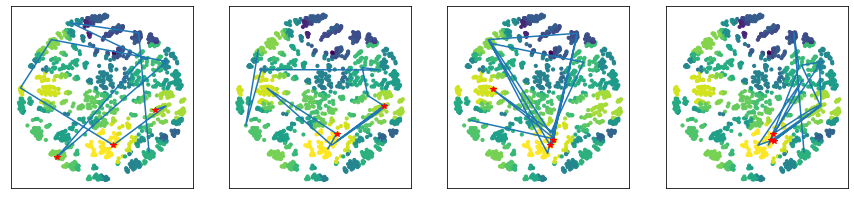

In [14]:
plot_trajectory(viz,50)

In [15]:
# PCA down to 20 dim using X
pca = PCA(n_components=10)
pca.fit(X)
Xpca20all = pca.transform(Xall)

# TSNE PCA20 to 2d
tsne = TSNE(n_components=2)
Xpcaall = tsne.fit_transform(Xpca20all)
viz = Xpcaall

/Users/promero/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/promero/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


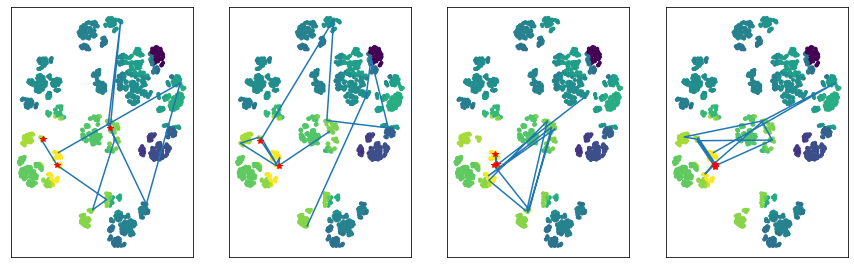

In [16]:
plot_trajectory(viz,50)

In [17]:
from sklearn.manifold import Isomap

# PCA down to 20 dim using X
pca = PCA(n_components=20)
pca.fit(X)
Xpca20all = pca.transform(Xall)

# MDS PCA20 to 2d
mds = Isomap(n_components=2)
Xpcaall = mds.fit_transform(Xpca20all)
viz = Xpcaall

/Users/promero/opt/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 7 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/promero/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/promero/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/promero/opt/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set

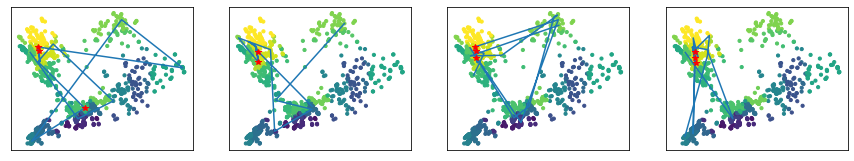

In [18]:
plot_trajectory(viz,50)

In [19]:
import umap

umap = umap.UMAP(random_state=42)
umap.fit(X)
Xumap = umap.transform(Xall)
viz = Xumap

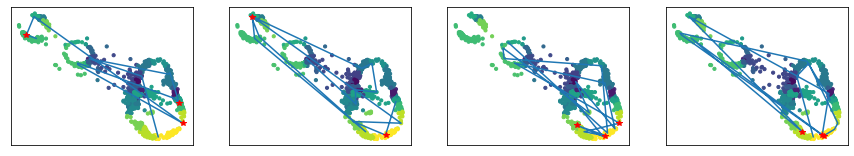

In [20]:
plot_trajectory(viz,50)

In [21]:
import umap

# PCA down to 20 dim using X
pca = PCA(n_components=20)
pca.fit(X)
Xpca20 = pca.transform(X)
Xpca20all = pca.transform(Xall)

# umap PCA20 to 2D
umap = umap.UMAP(random_state=42)
umap.fit(Xpca20)
Xumap = umap.transform(Xpca20all)
viz = Xumap

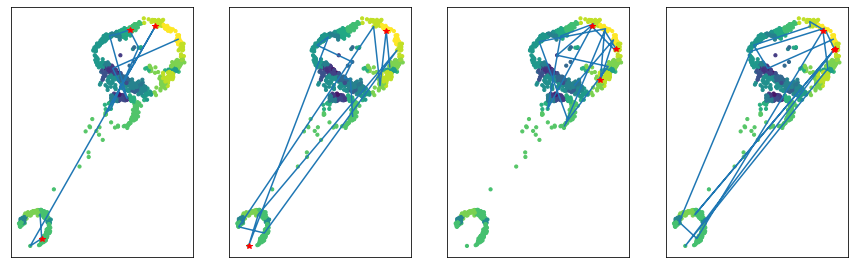

In [22]:
plot_trajectory(viz,50)